In [1]:
include("../Algebra/Gradients.jl")
include("../Algebra/Hamiltonians.jl")
include("../Algebra/Matrices.jl")
include("../Algebra/Propagators.jl")
include("../Amplitudes/Chebyshev.jl")
include("../Costs/Costs.jl")
include("../Gates/Xgate.jl")

U2 (generic function with 1 method)

In [2]:
using LinearAlgebra, Optim, Plots, Measures

In [3]:
ω_c = 5
ω_q = 3
χ = 3e-3
N = 4
amp_c = 1
amp_q = 1
T = 100

100

### Target gate

In [4]:
I_qubit = Matrix(I,2,2)
I_cavity = Matrix(I,N,N)
#X_gate = kron(x_gate(N, Array[[3,4], [5,6], [7,8]]), I_qubit)
#X_gate = kron(x_gate(N, Array[[1,2]]), I_qubit)
X_gate = kron(x_gate(N, Array[[3,4]]), I_qubit)

θ = π/2.5
RZ = kron(Rz(N, Array[[1,3]], θ), I_qubit)
RX = kron(Rx(N, Array[[3,4]], θ/2), I_qubit)

sx = kron(I_cavity, [0 1; 1 0])
sy = kron(I_cavity, [0 -1im; 1im 0])
# generating matrices
a,adag,sp,sm,sz = generate_matrices(N)

ψ_initial = zeros(N)
ψ_initial[1] = 1
ψ_initial = kron(ψ_initial/norm(ψ_initial), [0,1])

interaction_transformation(t) = exp(-1im * (ω_c * a' * a + ω_q / 2 * sz) * t)
int_transformation = interaction_transformation(T)

# ψ_initial = [0.0
# 0.042364880640716744
# 0.0
# 0.28885144075298463
# 0.0
# 0.16339860379664017
# 0.0
# 0.4589052841372305
# 0.0
# 0.5284511784719409
# 0.0
# 0.22306739569809422
# 0.0
# 0.3219611737913927
# 0.0
# 0.4947708459988468]
# ψ_final_x = RX * ψ_initial
# ψ_final_x_gate = X_gate * ψ_initial

8×8 Matrix{ComplexF64}:
 0.699251+0.714876im       0.0+0.0im       …       0.0+0.0im
      0.0+0.0im       0.699251-0.714876im          0.0+0.0im
      0.0+0.0im            0.0+0.0im               0.0+0.0im
      0.0+0.0im            0.0+0.0im               0.0+0.0im
      0.0+0.0im            0.0+0.0im               0.0+0.0im
      0.0+0.0im            0.0+0.0im       …       0.0+0.0im
      0.0+0.0im            0.0+0.0im               0.0+0.0im
      0.0+0.0im            0.0+0.0im          0.633413+0.773814im

In [5]:
H_drift = χ * adag * a * sz / 2 #+ ω_c * adag * a + ω_q * sz / 2

8×8 Matrix{Float64}:
 0.0  0.0  0.0      0.0     0.0     0.0    0.0      0.0
 0.0  0.0  0.0      0.0     0.0     0.0    0.0      0.0
 0.0  0.0  0.0015   0.0     0.0     0.0    0.0      0.0
 0.0  0.0  0.0     -0.0015  0.0     0.0    0.0      0.0
 0.0  0.0  0.0      0.0     0.003   0.0    0.0      0.0
 0.0  0.0  0.0      0.0     0.0    -0.003  0.0      0.0
 0.0  0.0  0.0      0.0     0.0     0.0    0.0045   0.0
 0.0  0.0  0.0      0.0     0.0     0.0    0.0     -0.0045

In [6]:
function cost_from_0_dispersive(H_drift, sp, sm, a, adag, T, δt, coefficients, unitary, ω_c, ω_q, initial_state, final_state, amp_q=1e-1, amp_c=1e-1)

    # initialising the propagator
    dim = size(H_drift,1)
    propagator = Matrix{ComplexF64}(I,dim,dim)
    amplitude_c(t) = chebyshev_amplitude(coefficients[1:Int(length(coefficients)/2)], T, t)
    amplitude_q(t) = chebyshev_amplitude(coefficients[Int(length(coefficients)/2) + 1:end], T, t)

    # time ordered product of the single exponential matrices
    # is this true at all? or we need more time steps aniway?
    for l in 0:δt:T
        H = H_drift + amp_q * (amplitude_q(l) * sp + amplitude_q(l)' * sm) + amp_c * (amplitude_c(l) * a +  amplitude_c(l)' * adag)
        infinitesimal_propagator  = cis(- H * δt)
        propagator = infinitesimal_propagator * propagator
    end

    c = final_state' * propagator * initial_state
   
    return 1 - norm(c)^2
end

function cost_from_0_dispersive_gate(H_drift, sp, sm, a, adag, T, δt, coefficients, unitary, ω_c, ω_q, amp_q, amp_c)

    # initialising the propagator
    dim = size(H_drift,1)
    propagator = Matrix{ComplexF64}(I,dim,dim)
    amplitude_c(t) = chebyshev_amplitude(coefficients[1:Int(length(coefficients)/2)], T, t)
    amplitude_q(t) = chebyshev_amplitude(coefficients[Int(length(coefficients)/2) + 1:end], T, t)

    # time ordered product of the single exponential matrices
    # is this true at all? or we need more time steps aniway?
    for l in 0:δt:T
        H = H_drift + amp_q * (amplitude_q(l) * sp + amplitude_q(l)' * sm) + amp_c * (amplitude_c(l) * a +  amplitude_c(l)' * adag)
        infinitesimal_propagator  = cis(- H * δt)
        propagator = infinitesimal_propagator * propagator
    end

    c = tr(unitary' * int_transformation * propagator)/dim
   
    return 1 - norm(c)^2
end

function cost_from_0_dispersive_gate_non_interaction(H_drift, sp, sm, a, adag, T, δt, coefficients, unitary, ω_c, ω_q, amp_q, amp_c)

    # initialising the propagator
    dim = size(H_drift,1)
    propagator = Matrix{ComplexF64}(I,dim,dim)
    amplitude_c(t) = chebyshev_amplitude(coefficients[1:Int(length(coefficients)/2)], T, t)
    amplitude_q(t) = chebyshev_amplitude(coefficients[Int(length(coefficients)/2) + 1:end], T, t)

    # time ordered product of the single exponential matrices
    # is this true at all? or we need more time steps aniway?
    for l in 0:δt:T
        H = H_drift + amp_q * (amplitude_q(l) * sp + amplitude_q(l)' * sm) + amp_c * (amplitude_c(l) * a +  amplitude_c(l)' * adag)
        infinitesimal_propagator  = cis(- H * δt)
        propagator = infinitesimal_propagator * propagator
    end

    c = tr(unitary' * propagator)/dim
   
    return 1 - norm(c)^2
end

function propagator(H_drift, sp, sm, a, adag, T, δt, coefficients)

    # initialising the propagator
    dim = size(H_drift,1)
    propagator = Matrix{ComplexF64}(I,dim,dim)

    amplitude_c = [ChebyshevT(coefficients[1:Int(length(coefficients)/2)])((2t - T)/T) for t in 0:δt:T]
    amplitude_q = [ChebyshevT(coefficients[Int(length(coefficients)/2) + 1:end])((2t - T)/T) for t in 0:δt:T]


    # time ordered product of the single exponential matrices
    # is this true at all? or we need more time steps aniway?
    for n in 1:1:Int(T/δt)+1
        H = H_drift + (amplitude_q(n) * sp + amplitude_q(n)' * sm) + (amplitude_c(n) * a + amplitude_c(n)' * adag)
        infinitesimal_propagator  = cis(- H * δt)
        propagator = infinitesimal_propagator * propagator
    end

    return propagator * exp(-1im*angle(propagator[8, 8]))
    
end

function gradient(coefficients, unitary, N, h, cost_before_increment,cost)

    L = length(coefficients)
    gradient = zeros(L)

    for i in 1:L
        coeffs_copy = copy(coefficients)
        coeffs_copy[i] = coefficients[i] + h
        gradient[i] = (cost(coeffs_copy) - cost_before_increment) / h
    end

    return gradient

end

gradient (generic function with 2 methods)

In [7]:
snap(x) = kron(Diagonal(exp.(-1im.*x)),I_qubit)
snap_params = rand(N) * 2 * pi .- pi
SNAP_GATE = snap(snap_params)

8×8 Matrix{ComplexF64}:
 -0.506216-0.862407im       -0.0-0.0im       …       0.0+0.0im
      -0.0-0.0im       -0.506216-0.862407im          0.0+0.0im
       0.0+0.0im             0.0+0.0im               0.0+0.0im
       0.0+0.0im             0.0+0.0im               0.0+0.0im
       0.0+0.0im             0.0+0.0im               0.0+0.0im
       0.0+0.0im             0.0+0.0im       …       0.0+0.0im
       0.0+0.0im             0.0+0.0im               0.0-0.0im
       0.0+0.0im             0.0+0.0im          0.998333-0.0577178im

In [8]:
f(x) = cost_from_0_dispersive(H_drift, sp, sm, a, adag, T, T / (10 * 3) , x, X_gate, ω_c, ω_q, ψ_initial, ψ_final_x)
g(x) = cost_from_0_dispersive_gate_non_interaction(H_drift, sp, sm, a, adag, T, T/50, x, X_gate, ω_c, ω_q, 1, 1)
h(x) = cost_from_0_dispersive_gate(H_drift, sp, sm, a, adag, T, T/50, x, X_gate, ω_c, ω_q, 1, 1)

h (generic function with 1 method)

In [ ]:
for i in 1:1
    println("iteration number: ", i )
    rand_coeffs_20 = rand(16)*2 .-1 + (rand(16)*2im .-1im)
    res_LBFGS = Optim.optimize(g, rand_coeffs_20 , LBFGS(), Optim.Options(show_trace=true, show_every=5, iterations=100))
    println(Optim.minimizer(res_LBFGS))
    println(Optim.minimum(res_LBFGS))
    rand_coeffs_20 = zeros(4) + (zeros(4)*im)
    res_LBFGS = Optim.optimize(g, [Optim.minimizer(res_LBFGS)[1:8]...,rand_coeffs_20...,Optim.minimizer(res_LBFGS)[9:end]...,rand_coeffs_20...] , LBFGS(), Optim.Options(show_trace=true, show_every=5,iterations=200))
    println(Optim.minimizer(res_LBFGS))
    println(Optim.minimum(res_LBFGS))
    res_LBFGS = Optim.optimize(g, [Optim.minimizer(res_LBFGS)[1:12]...,rand_coeffs_20...,Optim.minimizer(res_LBFGS)[13:end]...,rand_coeffs_20...] , LBFGS(), Optim.Options(show_trace=true, show_every=5,iterations=200))
    println(Optim.minimizer(res_LBFGS))
    println(Optim.minimum(res_LBFGS))
    res_LBFGS = Optim.optimize(g, [Optim.minimizer(res_LBFGS)[1:16]...,rand_coeffs_20...,Optim.minimizer(res_LBFGS)[17:end]...,rand_coeffs_20...] , LBFGS(), Optim.Options(show_trace=true, show_every=5,iterations=200))
    println(Optim.minimizer(res_LBFGS))
    println(Optim.minimum(res_LBFGS))
    res_LBFGS = Optim.optimize(g, [Optim.minimizer(res_LBFGS)[1:20]...,rand_coeffs_20...,Optim.minimizer(res_LBFGS)[21:end]...,rand_coeffs_20...] , LBFGS(), Optim.Options(show_trace=true, show_every=5,iterations=300))
    println(Optim.minimizer(res_LBFGS))
    println(Optim.minimum(res_LBFGS))
end

In [9]:
for i in 1:1
    println("iteration number: ", i )
    rand_coeffs_20 = rand(16)*2 .-1 + (rand(16)*2im .-1im)
    res_LBFGS = Optim.optimize(g, rand_coeffs_20 , LBFGS(), Optim.Options(show_trace=true, show_every=10))
    println(Optim.minimizer(res_LBFGS))
    println(Optim.minimum(res_LBFGS))
end

iteration number: 1
Iter     Function value   Gradient norm 


     0     9.926259e-01     6.790322e-01
 * time: 0.02506089210510254


    10     5.184596e-01     1.665053e+00
 * time: 2.1406638622283936


    20     3.526615e-01     2.142918e+00
 * time: 3.1169350147247314


    30     1.853918e-01     2.642344e+00
 * time: 4.071892023086548


    40     1.076932e-01     1.953827e+00
 * time: 5.011214017868042


    50     6.455843e-02     1.864221e+00
 * time: 5.947142839431763


    60     4.771624e-02     5.887028e-01
 * time: 6.864344835281372


    70     4.666635e-02     2.690726e-01
 * time: 7.838892936706543


    80     4.621658e-02     7.451967e-02
 * time: 8.786566972732544


    90     4.521468e-02     3.024800e-01
 * time: 9.823954820632935


   100     4.373502e-02     3.478769e-01
 * time: 10.786078929901123


   110     4.230109e-02     4.208038e-01
 * time: 11.771838903427124


   120     4.059349e-02     2.566115e-01
 * time: 12.756157875061035


   130     3.960098e-02     1.716273e-01
 * time: 13.684484958648682


   140     3.881227e-02     6.255476e-01
 * time: 14.616135835647583


   150     3.794958e-02     5.824023e-01
 * time: 15.532074928283691


   160     3.707626e-02     2.569878e-01
 * time: 16.46066904067993


   170     3.665652e-02     2.161122e-01
 * time: 17.43046283721924


   180     3.648799e-02     1.469563e-01
 * time: 18.43337082862854


   190     3.622749e-02     1.171110e-01
 * time: 19.402540922164917


   200     3.611563e-02     1.114711e-01
 * time: 20.34873104095459


   210     3.574633e-02     1.728551e-01
 * time: 21.28372097015381


   220     3.527799e-02     3.956395e-01
 * time: 22.169836044311523


   230     3.489941e-02     4.527845e-01
 * time: 23.08523201942444


   240     3.376179e-02     9.673627e-01
 * time: 23.96367597579956


   250     3.031766e-02     9.993751e-01
 * time: 24.90109395980835


   260     2.754826e-02     8.036174e-01
 * time: 25.763152837753296


   270     2.636232e-02     1.285852e-01
 * time: 26.704346895217896


   280     2.530089e-02     3.234106e-01
 * time: 27.67452883720398


   290     2.418301e-02     3.546860e-01
 * time: 28.67201805114746


   300     2.343279e-02     1.430431e-01
 * time: 29.683148860931396


   310     2.306419e-02     2.765161e-01
 * time: 30.661975860595703


   320     2.149240e-02     8.810935e-01
 * time: 31.637739896774292


   330     2.038533e-02     8.864405e-01
 * time: 32.50647187232971


   340     1.923350e-02     6.009227e-01
 * time: 33.342450857162476


   350     1.784223e-02     6.361967e-01
 * time: 34.27691602706909


   360     1.634393e-02     3.332018e-01
 * time: 35.12135100364685


   370     1.448977e-02     1.109014e+00
 * time: 35.94734501838684


   380     1.291052e-02     9.020615e-01
 * time: 36.84766888618469


   390     1.100834e-02     4.606091e-01
 * time: 37.7379789352417


   400     9.274578e-03     3.458099e-01
 * time: 38.64718794822693


   410     8.131435e-03     8.355841e-01
 * time: 39.554242849349976


   420     7.494597e-03     2.061496e-01
 * time: 40.39265298843384


   430     7.015944e-03     2.503236e-01
 * time: 41.43246603012085


   440     6.313698e-03     5.198785e-01
 * time: 42.40982794761658


   450     5.692579e-03     2.170504e-01
 * time: 43.39131784439087


   460     5.394294e-03     2.278425e-01
 * time: 44.38305902481079


   470     5.285033e-03     6.132411e-02
 * time: 45.36802101135254


   480     4.873963e-03     3.544346e-01
 * time: 46.344143867492676


   490     4.422199e-03     3.220273e-01
 * time: 47.332648038864136


   500     4.110573e-03     2.505047e-01
 * time: 48.31665897369385


   510     3.765717e-03     1.088547e-01
 * time: 49.34022903442383


   520     3.367383e-03     7.049708e-01
 * time: 50.31863188743591


   530     2.864569e-03     1.668078e-01
 * time: 51.227659940719604


   540     2.495655e-03     4.284417e-01
 * time: 52.23808193206787


   550     2.339765e-03     2.952075e-01
 * time: 53.243664026260376


   560     2.193514e-03     1.069289e-01
 * time: 54.14740204811096


   570     2.127012e-03     5.714932e-02
 * time: 55.11187386512756


   580     2.083469e-03     6.206496e-02
 * time: 56.18740391731262


   590     2.055805e-03     4.840633e-02
 * time: 57.169692039489746


   600     2.035838e-03     4.530256e-02
 * time: 58.24787497520447


   610     1.997835e-03     5.230978e-02
 * time: 59.31642484664917


   620     1.957938e-03     3.279577e-01
 * time: 60.24312996864319


   630     1.937402e-03     7.463784e-02
 * time: 61.4095778465271


   640     1.926096e-03     2.003946e-02
 * time: 62.443617820739746


   650     1.915394e-03     9.659691e-03
 * time: 63.391183853149414


   660     1.899022e-03     3.125888e-02
 * time: 64.41601896286011


   670     1.891742e-03     2.487423e-02
 * time: 65.39184284210205


   680     1.883695e-03     3.322775e-02
 * time: 66.46024990081787


   690     1.874240e-03     4.637162e-02
 * time: 67.60278987884521


   700     1.865308e-03     5.917267e-02
 * time: 68.57802104949951


   710     1.826782e-03     4.875347e-02
 * time: 69.59072089195251


   720     1.758862e-03     5.832496e-02
 * time: 70.68658304214478


   730     1.665194e-03     1.131274e-01
 * time: 71.5741879940033


   740     1.612850e-03     1.567258e-01
 * time: 72.49993896484375


   750     1.538536e-03     2.710114e-01
 * time: 73.37729001045227


   760     1.477134e-03     1.089116e-01
 * time: 74.34380388259888


   770     1.379698e-03     2.656173e-01
 * time: 75.23879885673523


   780     1.314904e-03     1.393713e-01
 * time: 76.23829698562622


   790     1.274832e-03     1.635490e-01
 * time: 77.34529399871826


   800     1.256217e-03     3.848331e-02
 * time: 78.28422999382019


   810     1.245243e-03     2.959049e-02
 * time: 79.41663789749146


   820     1.233870e-03     2.933480e-02
 * time: 80.41045594215393


   830     1.205458e-03     5.305116e-02
 * time: 81.48556685447693


   840     1.187720e-03     3.523785e-02
 * time: 82.53274488449097


   850     1.179154e-03     5.226203e-02
 * time: 83.63098382949829


   860     1.168269e-03     6.680820e-02
 * time: 84.77451992034912


   870     1.153046e-03     7.442743e-02
 * time: 85.8490400314331


   880     1.140650e-03     2.004301e-02
 * time: 86.84573197364807


   890     1.134444e-03     2.765297e-02
 * time: 87.90146803855896


   900     1.128018e-03     2.846470e-02
 * time: 88.86679601669312


   910     1.113336e-03     4.811751e-02
 * time: 89.8222119808197


   920     1.098983e-03     1.021586e-01
 * time: 90.85161089897156


   930     1.088493e-03     8.897137e-02
 * time: 91.92486190795898


   940     1.078913e-03     8.075145e-02
 * time: 92.94746088981628


   950     1.065232e-03     1.251512e-01
 * time: 93.93368196487427


   960     1.045274e-03     2.878200e-02
 * time: 94.93089890480042


   970     1.019924e-03     8.558548e-02
 * time: 96.10758399963379


   980     9.925735e-04     5.821959e-02
 * time: 97.11300897598267


   990     9.731184e-04     1.092447e-01
 * time: 98.15426588058472


  1000     9.578717e-04     6.858154e-02
 * time: 99.22067093849182


ComplexF64[-0.08321152564521846 + 1.0975469608951722im, 0.478314309101286 + 0.5409426833583145im, -0.9353269834848502 - 0.8828035492196981im, -0.3702960557216703 - 0.16491117062101676im, -0.3478987056585296 + 1.0008266926627225im, 0.7859865828905993 + 0.38711442612815566im, -0.26606505726393875 - 0.6461032045028199im, 0.027141091107158496 - 0.7896599295045894im, -0.11866691295782676 - 0.3623811507020616im, -0.6944924407564986 + 0.24340242290165373im, 0.016506201852268528 + 0.6847011645702455im, -0.6186530233001157 - 0.30869434069070023im, -0.15439905074116722 - 0.027224426216059583im, -0.03246307373191657 + 0.10888804049687156im, -0.24875545804974178 - 0.693519628319181im, -0.6137045124161413 + 0.5401436235808048im]
0.0009578716585060265


In [32]:
# optimised_coeffs = ComplexF64[-0.08321152564521846 + 1.0975469608951722im, 0.478314309101286 + 0.5409426833583145im, -0.9353269834848502 - 0.8828035492196981im, -0.3702960557216703 - 0.16491117062101676im, -0.3478987056585296 + 1.0008266926627225im, 0.7859865828905993 + 0.38711442612815566im, -0.26606505726393875 - 0.6461032045028199im, 0.027141091107158496 - 0.7896599295045894im, -0.11866691295782676 - 0.3623811507020616im, -0.6944924407564986 + 0.24340242290165373im, 0.016506201852268528 + 0.6847011645702455im, -0.6186530233001157 - 0.30869434069070023im, -0.15439905074116722 - 0.027224426216059583im, -0.03246307373191657 + 0.10888804049687156im, -0.24875545804974178 - 0.693519628319181im, -0.6137045124161413 + 0.5401436235808048im]
# res_LBFGS = Optim.optimize(g, optimised_coeffs , LBFGS(), Optim.Options(show_trace=true, show_every=10))
optimised_coeffs = ComplexF64[-0.6193790376405239 + 0.3430319807068753im, -1.0366612749571087 - 0.017561971812308372im, 0.0029344326904683343 + 0.6861679732685254im, 0.6242532563965949 + 0.03929732884385581im, -0.4267779959855678 + 0.7796583535881609im, 0.7168446803926989 - 1.1732208391276846im, -0.4217303838218876 - 0.46434720172374977im, 0.6897444737856485 + 0.5252706748983021im, 0.6584712904444318 + 0.276510257664745im, -0.4982010094028265 + 0.048689230678144985im, 0.45068568884665927 + 0.921355167236885im, 0.9224109218940248 - 1.104517043749335im, -0.5877560103315975 + 0.8040894624100644im, 0.20566180589467853 - 0.12477824491793979im, 0.3492523289377559 - 0.6192618699460064im, 1.0929632348088747 - 0.9315970120719389im, -0.595198741610121 - 0.37514949140770065im, 0.33388632080052694 - 0.23277366085823017im, 0.15819457793264569 + 0.5913784125361112im, 0.3820435419471546 + 0.4326899881333753im, 0.39968316192611164 + 0.5922421455177349im, 1.0089201337570546 - 0.7991523982015514im, -1.1659733457382588 + 0.2456043774073477im, 0.7480337112458456 + 0.39687788669924184im, -1.0492837479708974 - 1.0062071981710161im, -0.06774574014058606 - 0.029391474268202714im, 0.05892926268462071 - 0.08936775815828264im, -0.05815351756629147 - 0.003965408844572092im, -0.041359668978394534 + 0.0038388843776757486im, 0.04462371234275593 + 0.006543542911414281im, 0.029991177851707726 - 0.020088784148460975im, -0.9201453930146751 + 0.43207761423786123im, -0.48710080736958244 - 0.059728975030165464im, -0.34291053196916194 + 0.6268532430488426im, -0.8982725536241989 + 0.5554901318178004im, -0.4368386125801733 + 0.09171392743762186im, -0.12035746813596392 - 0.10772312872720394im, -0.5842585338922934 + 0.5040023995972445im, -0.5612204654384688 + 0.4853552857646275im, -0.33155135325074253 + 0.4323348543743697im, -0.6863896381627227 - 0.9378892649669784im, 0.5528732840372953 + 0.4445634094886239im, -0.8690406954095505 - 0.14000116850068353im, -0.03258914055220573 - 0.9635021258591429im, 0.04468604016130936 + 0.18138030117184706im, 0.6448396943111064 - 0.6388143926984707im, 0.6171017778091858 - 1.0239823564380381im, 0.4357334741077078 + 0.833983403040961im, -0.40156092926851755 - 0.8423039162733705im, -0.8697523693618248 + 0.8444285281054749im, 0.5723206471551345 + 0.7635882761960228im, 0.571986784642736 + 0.1395651191408393im, -0.28659121357450584 - 0.26105524812605113im, 0.2658528716759598 - 0.3213092174116696im, 0.3920541455448738 + 0.08154772667346653im, -0.3258500797313976 + 0.732007776425596im, 0.0007035907818728055 + 0.0014122496251437109im, 0.0016235930433160359 + 0.0011165143664516428im, -0.0026923538977898427 - 0.0009387228554957413im, 0.0005743474380771323 - 0.004398549080694252im, 0.0025935933412075743 + 0.0008477832165435366im, -0.00021445312248309038 + 0.0002782437499440995im]

62-element Vector{ComplexF64}:
     -0.6193790376405239 + 0.3430319807068753im
     -1.0366612749571087 - 0.017561971812308372im
   0.0029344326904683343 + 0.6861679732685254im
      0.6242532563965949 + 0.03929732884385581im
     -0.4267779959855678 + 0.7796583535881609im
      0.7168446803926989 - 1.1732208391276846im
     -0.4217303838218876 - 0.46434720172374977im
      0.6897444737856485 + 0.5252706748983021im
      0.6584712904444318 + 0.276510257664745im
     -0.4982010094028265 + 0.048689230678144985im
                         ⋮
      0.2658528716759598 - 0.3213092174116696im
      0.3920541455448738 + 0.08154772667346653im
     -0.3258500797313976 + 0.732007776425596im
   0.0007035907818728055 + 0.0014122496251437109im
   0.0016235930433160359 + 0.0011165143664516428im
  -0.0026923538977898427 - 0.0009387228554957413im
   0.0005743474380771323 - 0.004398549080694252im
   0.0025935933412075743 + 0.0008477832165435366im
 -0.00021445312248309038 + 0.0002782437499440995im

In [16]:
optimised_coeffs = Optim.minimizer(res_LBFGS)
println(optimised_coeffs)

ComplexF64[0.17760715572957647 + 0.9923452674731341im, 0.6101869409717107 + 0.5268561279716014im, -1.2016472541152075 - 0.7589932919800506im, -0.4458467369675481 + 0.09499855986844917im, -0.07218245414726641 + 0.9030359730383563im, 0.8334409772697331 + 0.24627063101817065im, -0.4038351493796472 - 0.6565319895865439im, -0.20167239260133824 - 0.6872471895996161im, -0.07701073909102776 - 0.4374400096207094im, -0.6792200431905919 + 0.19379011202627563im, -0.029899459520501437 + 0.6846948113387414im, -0.6915890370228753 - 0.3106123283420875im, -0.14816340801036 - 0.029479836084546397im, 0.07495686220731611 + 0.14040151088827765im, -0.1755507688469939 - 0.571796132331867im, -0.5423211523963868 + 0.5980039338490384im]


In [33]:
coeffs_cavity = optimised_coeffs[1:31]
coeffs_qubit = optimised_coeffs[32:end]

31-element Vector{ComplexF64}:
     -0.9201453930146751 + 0.43207761423786123im
    -0.48710080736958244 - 0.059728975030165464im
    -0.34291053196916194 + 0.6268532430488426im
     -0.8982725536241989 + 0.5554901318178004im
     -0.4368386125801733 + 0.09171392743762186im
    -0.12035746813596392 - 0.10772312872720394im
     -0.5842585338922934 + 0.5040023995972445im
     -0.5612204654384688 + 0.4853552857646275im
    -0.33155135325074253 + 0.4323348543743697im
     -0.6863896381627227 - 0.9378892649669784im
                         ⋮
      0.2658528716759598 - 0.3213092174116696im
      0.3920541455448738 + 0.08154772667346653im
     -0.3258500797313976 + 0.732007776425596im
   0.0007035907818728055 + 0.0014122496251437109im
   0.0016235930433160359 + 0.0011165143664516428im
  -0.0026923538977898427 - 0.0009387228554957413im
   0.0005743474380771323 - 0.004398549080694252im
   0.0025935933412075743 + 0.0008477832165435366im
 -0.00021445312248309038 + 0.0002782437499440995im

In [34]:
d=5
amplitude_c(t) = chebyshev_amplitude(coeffs_cavity, T*d, t)
amplitude_q(t) = chebyshev_amplitude(coeffs_qubit, T*d, t)

amps_c = [amplitude_c(l)/d for l in 0:T*d/(100):T*d]
amps_q = [amplitude_q(l)/d for l in 0:T*d/(100):T*d]

101-element Vector{ComplexF64}:
  0.26262798237379137 + 0.8917803548832793im
  -0.2750081392289637 - 0.2108265774192791im
  -0.5382167274833105 + 0.13407360182402162im
  -0.4195316593806636 + 0.24902331064301567im
 -0.22790151290651658 + 0.15591745240711635im
  -0.0624834184978992 - 0.017921888327825996im
  0.09122076484359694 - 0.21191737017336734im
  0.23504900058887573 - 0.36350790213758427im
   0.3318715636656833 - 0.3948540130691095im
  0.33871143294766126 - 0.25245103565952914im
                      ⋮
 -0.05753653858773074 - 0.21810151544684037im
  0.03517110474925341 - 0.3733004232452109im
  0.07788439024330267 - 0.4595679729647125im
  0.09883097449955613 - 0.4182058300954088im
  0.10853500235669351 - 0.16309658671743854im
  0.03946528908767348 + 0.317247077203249im
 -0.25739075142906814 + 0.7462459029006503im
  -0.8026863168122794 + 0.5534701694335917im
  -0.8108785496612952 + 0.37017994430226364im

In [20]:
# plt2to6 = plot(1:1:8, costs_2to6, label="2 -> 6", linestyle=:dash, marker = :circle, yaxis=:log, legend=:bottomleft, xlim=(0.5,8.5), xlabel="Circuit depth", ylabel="Pulse [GHz]", yticks=exp10.(range(-16, stop=0, length=17)))
# plt0to4 = plot!(1:1:8, costs_0to4, label="0 -> 4", linestyle=:dash, marker = :circle, )
# pltSuperposition = plot!(1:1:8, costs_superposition, label="0 -> superposition", linestyle=:dash, marker = :circle )
# plt0to7 = plot!(1:1:8, costs, label="0 -> 7", linestyle=:dash, marker = :circle, fmt = :jpeg)


In [35]:
imaginary_part = plot([l for l in 0:T*d /100:T*d], imag(amps_c), label = "Im[ϵ(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, layout=2, subplot=1, size=(1500,300), margin=10mm,xtickfontsize=14,ytickfontsize=14,xguidefontsize=14,yguidefontsize=14,legendfontsize=14)
real_part = plot!([l for l in 0:T*d /100:T*d], real(amps_c), label= "Re[ϵ(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=1)
imaginary_part = plot!([l for l in 0:T*d /100:T*d], imag(amps_q), label = "Im[Ω(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=2, xtickfontsize=14,ytickfontsize=14,xguidefontsize=14,yguidefontsize=14,legendfontsize=14)
real_part = plot!([l for l in 0:T*d /100:T*d], real(amps_q), label= "Re[Ω(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=2)
savefig("../../plots/pulse_optimisation/x7photons_100timesteps_100ns_1dote-2Infidelity.pdf")

"/Users/andreamaestri/Desktop/Thesis_julia/Opt3DQalgs/BTgates/plots/pulse_optimisation/x7photons_100timesteps_100ns_1dote-2Infidelity.pdf"

In [208]:
g(x) = cost_from_0_dispersive_gate(H_drift, sp, sm, a, adag, T, T / (50), x, RZ, ω_c, ω_q, 1, 1)

g (generic function with 1 method)

In [211]:
res_reseding = Optim.optimize(g,optimised_coeffs[1:18] , LBFGS(), Optim.Options(show_trace=true, show_every=50))

Iter     Function value   Gradient norm 
     0     9.922960e-01     5.803536e-01
 * time: 0.00012111663818359375


    50     2.078448e-02     4.692864e-01
 * time: 8.529726028442383


   100     7.979614e-03     1.583134e-01
 * time: 15.381660223007202


   150     4.988489e-03     2.260267e-01
 * time: 22.4797260761261


   200     2.788210e-03     6.930021e-02
 * time: 29.811928033828735


   250     1.740306e-04     1.434851e-01
 * time: 36.76603412628174


   300     5.128522e-06     3.499403e-03
 * time: 44.01628017425537


   350     5.060267e-06     3.005272e-05
 * time: 51.43936109542847


   400     5.060421e-06     2.535875e-04
 * time: 130.4956090450287


   450     5.060515e-06     1.443594e-03
 * time: 256.7781641483307


   500     5.060768e-06     2.291083e-04
 * time: 411.36923122406006


   550     5.061021e-06     1.526638e-04
 * time: 588.3723030090332


   600     5.061274e-06     1.578130e-04
 * time: 716.4642021656036


   650     5.029828e-06     7.472034e-04
 * time: 815.6598570346832


   700     4.994863e-06     5.278896e-04
 * time: 914.0920941829681


   750     4.995113e-06     2.487467e-04
 * time: 1049.6746611595154


   800     4.995362e-06     6.126404e-04
 * time: 1183.0039281845093


   850     4.995516e-06     1.401902e-03
 * time: 1314.70143699646


   900     4.955995e-06     2.147322e-03
 * time: 1415.4603490829468


   950     4.854043e-06     8.446929e-04
 * time: 1467.4686210155487


  1000     4.822512e-06     5.881347e-04
 * time: 1547.743804216385


 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     4.822512e-06

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 2.09e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.79e-06 ≰ 0.0e+00
    |f(x) - f(x')|         = 2.02e-10 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 4.18e-05 ≰ 0.0e+00
    |g(x)|                 = 5.88e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   1548  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    30427
    ∇f(x) calls:   30427


In [216]:
optimised_coeffs_2 = Optim.minimizer(res_reseding)

18-element Vector{ComplexF64}:
    3.53722302080442 - 0.8488793506814328im
 0.32030569539668813 + 1.0699550040938im
 -5.1593651237154345 - 0.02282548916338697im
 -5.5641553539989195 - 4.753114215050577im
 -0.4264005088388613 - 2.356411785666479im
  11.362275257694462 - 2.6698674523571997im
  1.9101181222604613 - 8.824547871948832im
  -3.536213168220117 + 5.865117958192369im
  2.8729965334521985 + 10.210345086310262im
 -2.1213470041628106 + 1.1933783006219911im
 -0.6010553842781797 + 0.7186681245048226im
  1.2542553557359015 - 1.05489644691511im
  0.1873988576777256 - 0.9269019656096693im
 -0.5033295253272662 + 0.4984054975217349im
  0.0696859677411764 + 0.5794533535233732im
 -0.1894439170182989 - 0.5474341953369269im
  0.3136885785391878 - 0.6834728240027771im
 0.20132680179443507 + 0.5810535836690036im

In [217]:
coeffs_cavity = optimised_coeffs_2[1:9]
coeffs_qubit = optimised_coeffs_2[10:end]

9-element Vector{ComplexF64}:
 -2.1213470041628106 + 1.1933783006219911im
 -0.6010553842781797 + 0.7186681245048226im
  1.2542553557359015 - 1.05489644691511im
  0.1873988576777256 - 0.9269019656096693im
 -0.5033295253272662 + 0.4984054975217349im
  0.0696859677411764 + 0.5794533535233732im
 -0.1894439170182989 - 0.5474341953369269im
  0.3136885785391878 - 0.6834728240027771im
 0.20132680179443507 + 0.5810535836690036im

In [218]:
amplitude_c(t) = chebyshev_amplitude(coeffs_cavity, T, t)
amplitude_q(t) = chebyshev_amplitude(coeffs_qubit, T, t)

amps_c = [amplitude_c(l) for l in 0:T/50:T]
amps_q = [amplitude_q(l)  for l in 0:T/50:T]

51-element Vector{ComplexF64}:
  -1.3282563086579495 + 0.9827600511449432im
  -0.8111687966276102 - 0.23071981947688913im
  -0.4773000985574959 - 0.45926477168630253im
 -0.31882129127460934 - 0.18734751574783726im
 -0.31494089249579194 + 0.25750301099240147im
 -0.43726019525144455 + 0.6702365178927421im
  -0.6540136014264155 + 0.9388814535312169im
  -0.9333237797010003 + 1.0197516593063902im
   -1.245594663725322 + 0.9168205793784087im
  -1.5651584969105874 + 0.6648436751032492im
                      ⋮
  -1.8907578484170577 + 1.5077459420362818im
  -1.7730736175967345 + 1.5654426671665038im
  -1.7435181443533996 + 1.6086109416790522im
  -1.7993307650031807 + 1.5991955300032656im
   -1.917909082416123 + 1.504062156524573im
   -2.048941349073288 + 1.303982607779015im
  -2.1050135749063186 + 1.0053425778169798im
  -1.9505351883136923 + 0.6549390208229573im
   -1.388820269298129 + 0.3582534279764422im

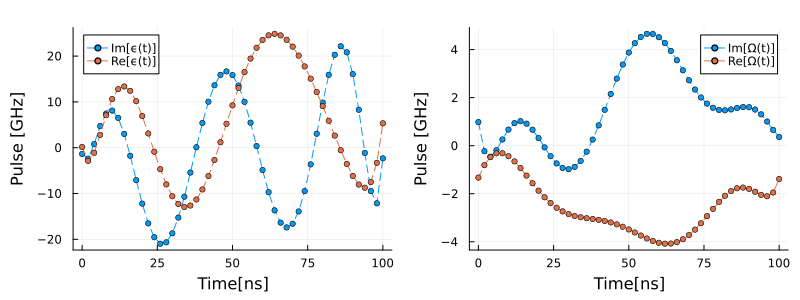

In [219]:
imaginary_part = plot([l for l in 0:T /50:T], imag(amps_c), label = "Im[ϵ(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, layout=2, subplot=1, size=(800,300), margin=5mm)
real_part = plot!([l for l in 0:T /50:T], real(amps_c), label= "Re[ϵ(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=1)
imaginary_part = plot!([l for l in 0:T /50:T], imag(amps_q), label = "Im[Ω(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=2)
real_part = plot!([l for l in 0:T /50:T], real(amps_q), label= "Re[Ω(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=2)


In [81]:
g(x) = cost_from_0_dispersive_gate(H_drift, sp, sm, a, adag, T*2, T*2 / (200), x, RZ, ω_c, ω_q, 1, 1)

g (generic function with 1 method)

In [82]:
res_reseding_2 = Optim.optimize(g,optimised_coeffs_2 , LBFGS(), Optim.Options(show_trace=true, show_every=10))

Iter     Function value   Gradient norm 
     0     9.748549e-01     1.430892e+01
 * time: 8.487701416015625e-5


    10     3.180773e-01     8.724509e+00
 * time: 8.935656070709229


    20     2.138561e-01     6.317534e+00
 * time: 12.885767936706543


    30     1.720050e-01     1.587296e+00
 * time: 16.54070496559143


    40     1.604174e-01     2.090709e+01
 * time: 19.969876050949097


    50     1.442503e-01     4.648444e+00
 * time: 22.93668794631958


    60     1.401386e-01     9.328704e-01
 * time: 26.213769912719727


    70     1.194498e-01     4.446220e+00
 * time: 29.62933087348938


    80     6.597298e-02     1.674366e+01
 * time: 32.873451948165894


    90     5.694424e-02     1.328090e+01
 * time: 36.608484983444214


   100     3.274473e-02     1.844956e+00
 * time: 39.99434304237366


   110     3.155086e-02     4.188403e-01
 * time: 43.62846899032593


   120     2.966058e-02     4.210779e-01
 * time: 46.78181505203247


   130     2.714986e-02     3.804311e+00
 * time: 50.228408098220825


   140     2.402749e-02     2.107431e+00
 * time: 53.628117084503174


   150     2.220077e-02     2.479324e+00
 * time: 57.12268900871277


   160     1.868934e-02     5.810640e-01
 * time: 60.531975984573364


   170     1.836193e-02     1.056320e+00
 * time: 64.78629493713379


   180     1.504040e-02     2.423546e+00
 * time: 67.806960105896


   190     1.427740e-02     1.045551e+00
 * time: 71.52440690994263


   200     1.352097e-02     9.840703e-01
 * time: 74.99141001701355


   210     1.324629e-02     2.175031e-01
 * time: 78.20150303840637


   220     1.311526e-02     2.642147e-01
 * time: 82.59172892570496


   230     1.300801e-02     2.682874e-01
 * time: 86.04789805412292


   240     1.283473e-02     8.497996e-01
 * time: 89.61627292633057


   250     1.218805e-02     4.615291e-01
 * time: 93.1940279006958


   260     1.157557e-02     1.058794e+00
 * time: 96.97179198265076


   270     1.136966e-02     4.227422e-01
 * time: 100.71230602264404


   280     1.084996e-02     7.688095e-01
 * time: 103.94794797897339


   290     1.048382e-02     5.591933e-01
 * time: 107.56514596939087


   300     1.009307e-02     1.368357e+00
 * time: 110.93537306785583


   310     9.776334e-03     5.792147e-01
 * time: 114.11103796958923


   320     9.368560e-03     1.514439e+00
 * time: 117.35563492774963


   330     8.558154e-03     1.885057e+00
 * time: 121.08529996871948


   340     8.142099e-03     4.874090e-01
 * time: 124.53097701072693


   350     8.033707e-03     8.152303e-01
 * time: 128.29415488243103


   360     7.372831e-03     2.966285e+00
 * time: 132.02536702156067


   370     6.439703e-03     4.967582e-01
 * time: 135.23150992393494


   380     6.102647e-03     4.071582e-01
 * time: 138.67573595046997


   390     5.656147e-03     2.205338e+00
 * time: 141.7935390472412


   400     4.985535e-03     4.911658e-01
 * time: 145.3867518901825


   410     4.519040e-03     3.219780e-01
 * time: 148.9885950088501


   420     4.001272e-03     1.820735e-01
 * time: 152.37942695617676


   430     3.843769e-03     2.765356e-01
 * time: 155.9743959903717


   440     3.703388e-03     1.982614e-01
 * time: 159.32836198806763


   450     3.290553e-03     1.354299e-01
 * time: 162.14467000961304


   460     2.244239e-03     1.478095e+00
 * time: 165.04271697998047


   470     1.880367e-03     1.270829e-01
 * time: 168.50390100479126


   480     1.579181e-03     2.512052e-01
 * time: 172.3686180114746


   490     1.065838e-03     8.033406e-01
 * time: 176.16389799118042


   500     9.094414e-04     2.952408e-02
 * time: 179.64057302474976


   510     8.574073e-04     2.266195e-01
 * time: 183.44630694389343


   520     8.517453e-04     1.355041e-01
 * time: 187.1534869670868


   530     8.366105e-04     7.556479e-02
 * time: 190.63951206207275


   540     8.276279e-04     2.101751e-01
 * time: 194.2064869403839


   550     7.603818e-04     3.187890e-01
 * time: 197.28005409240723


   560     6.994375e-04     3.471594e-01
 * time: 200.75492095947266


   570     6.262425e-04     4.896766e-02
 * time: 204.08902502059937


   580     6.009060e-04     2.991243e-01
 * time: 208.26310896873474


   590     5.895402e-04     2.441299e-01
 * time: 212.24090909957886


   600     5.140343e-04     1.423119e-01
 * time: 215.74039506912231


   610     5.071187e-04     3.668490e-02
 * time: 219.08179593086243


   620     5.067849e-04     4.787998e-02
 * time: 223.56490206718445


   630     4.990327e-04     2.356235e-01
 * time: 227.71379899978638


   640     4.694732e-04     1.312694e-01
 * time: 231.4495038986206


   650     4.645287e-04     2.782928e-02
 * time: 235.16919898986816


   660     4.637021e-04     1.399748e-02
 * time: 238.8795030117035


   670     4.633200e-04     3.038763e-02
 * time: 242.50104999542236


   680     4.611123e-04     2.262617e-02
 * time: 246.4257791042328


   690     4.513466e-04     7.793679e-02
 * time: 250.35258603096008


   700     4.480217e-04     1.716917e-02
 * time: 254.20162796974182


   710     4.382092e-04     1.611618e-01
 * time: 257.89428305625916


   720     4.253327e-04     9.943578e-02
 * time: 261.2376139163971


   730     4.183690e-04     1.357613e-01
 * time: 265.18229508399963


   740     4.066925e-04     6.100497e-02
 * time: 268.6075539588928


   750     3.999290e-04     4.301243e-02
 * time: 272.0554840564728


   760     3.966632e-04     1.297543e-01
 * time: 276.4829649925232


   770     3.920341e-04     1.282707e-01
 * time: 280.0938169956207


   780     3.555097e-04     1.644227e-01
 * time: 283.6114749908447


   790     3.245674e-04     3.151520e-02
 * time: 287.16858291625977


   800     3.050654e-04     1.436634e-01
 * time: 291.0065369606018


   810     2.772121e-04     2.112602e-01
 * time: 294.7294499874115


   820     2.621304e-04     2.971382e-01
 * time: 298.4694800376892


   830     2.405467e-04     3.626605e-01
 * time: 302.276221036911


   840     2.309879e-04     1.501145e-01
 * time: 305.8052649497986


   850     2.247769e-04     1.103581e-01
 * time: 309.6255190372467


   860     2.194594e-04     2.715696e-02
 * time: 313.29009199142456


   870     2.143893e-04     2.781840e-02
 * time: 317.5485038757324


   880     2.115678e-04     2.837767e-02
 * time: 320.96931290626526


   890     2.087792e-04     2.644724e-02
 * time: 324.9390139579773


   900     2.066779e-04     9.441076e-02
 * time: 328.90032601356506


   910     1.966599e-04     2.195793e-01
 * time: 332.6062378883362


   920     1.841904e-04     6.720949e-02
 * time: 338.72726488113403


   930     1.502130e-04     7.902088e-02
 * time: 343.35501289367676


   940     1.431218e-04     4.498018e-02
 * time: 347.56170105934143


   950     1.387378e-04     2.086956e-03
 * time: 351.07581400871277


   960     1.387203e-04     1.050801e-02
 * time: 355.6298608779907


   970     1.353563e-04     4.082934e-02
 * time: 359.46755290031433


   980     1.310510e-04     2.886688e-02
 * time: 363.2851278781891


   990     1.302154e-04     1.305744e-02
 * time: 367.1428918838501


  1000     1.297632e-04     1.534198e-03
 * time: 371.040874004364


 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     1.297632e-04

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 1.67e-04 ≰ 0.0e+00
    |x - x'|/|x'|          = 3.01e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 1.27e-08 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 9.76e-05 ≰ 0.0e+00
    |g(x)|                 = 1.53e-03 ≰ 1.0e-08

 * Work counters
    Seconds run:   371  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    2755
    ∇f(x) calls:   2755


In [89]:
optimised_coeffs_3 = Optim.minimizer(res_reseding_2)
res_reseding_2_bis = Optim.optimize(g,optimised_coeffs_3 , LBFGS(), Optim.Options(show_trace=true, show_every=10))

Iter     Function value   Gradient norm 
     0     1.297632e-04     1.534198e-03
 * time: 0.00011086463928222656


    10     1.282085e-04     9.980145e-03
 * time: 4.420332908630371


    20     1.268029e-04     1.801729e-02
 * time: 8.63766598701477


    30     1.264653e-04     3.943331e-03
 * time: 12.307608842849731


    40     1.249942e-04     4.484425e-02
 * time: 16.027992963790894


    50     1.239463e-04     1.214922e-02
 * time: 19.33669686317444


    60     1.238437e-04     3.767218e-03
 * time: 23.0885329246521


    70     1.238103e-04     1.095793e-03
 * time: 26.71631693840027


    80     1.236718e-04     2.340870e-03
 * time: 30.53391981124878


    90     1.222990e-04     2.373583e-02
 * time: 33.94151782989502


   100     1.214979e-04     2.185548e-02
 * time: 37.05632400512695


   110     1.212015e-04     7.595146e-03
 * time: 40.466399908065796


   120     1.210639e-04     6.541588e-03
 * time: 43.93107080459595


   130     1.210536e-04     2.245430e-03
 * time: 47.58021378517151


   140     1.210393e-04     1.531510e-03
 * time: 51.69838285446167


   150     1.210105e-04     3.463794e-03
 * time: 55.15007400512695


   160     1.209961e-04     2.698998e-03
 * time: 58.86929988861084


   170     1.209804e-04     2.209074e-03
 * time: 62.73550581932068


   180     1.209593e-04     5.110751e-03
 * time: 66.54794383049011


   190     1.209327e-04     3.279146e-03
 * time: 70.52721881866455


   200     1.207602e-04     5.825495e-02
 * time: 74.68600487709045


   210     1.199688e-04     2.417756e-02
 * time: 78.54080486297607


   220     1.196749e-04     4.293659e-03
 * time: 82.04720091819763


   230     1.192252e-04     1.663165e-02
 * time: 85.88193583488464


   240     1.189205e-04     4.020533e-03
 * time: 89.46893095970154


   250     1.186087e-04     1.067524e-02
 * time: 93.49329400062561


   260     1.182904e-04     8.309897e-03
 * time: 97.23538994789124


   270     1.182310e-04     1.852403e-02
 * time: 101.2950849533081


   280     1.179606e-04     5.588866e-03
 * time: 105.07846283912659


   290     1.179291e-04     2.780780e-03
 * time: 109.21662998199463


   300     1.178891e-04     3.997206e-03
 * time: 112.9785897731781


   310     1.178730e-04     7.770919e-04
 * time: 116.80948495864868


   320     1.176786e-04     1.412704e-02
 * time: 120.80929183959961


   330     1.175382e-04     2.275332e-03
 * time: 124.6048378944397


   340     1.175095e-04     3.153717e-03
 * time: 128.56586289405823


   350     1.175023e-04     4.588973e-04
 * time: 132.60681581497192


   360     1.174987e-04     3.081124e-03
 * time: 136.43839979171753


   370     1.174902e-04     2.493318e-03
 * time: 140.07455682754517


   380     1.174877e-04     6.676492e-04
 * time: 144.12674593925476


   390     1.174832e-04     1.364920e-03
 * time: 148.44828391075134


   400     1.174818e-04     2.318772e-03
 * time: 152.11584091186523


   410     1.174753e-04     8.577797e-04
 * time: 155.9290897846222


   420     1.174747e-04     1.565378e-03
 * time: 159.9671049118042


   430     1.174744e-04     2.685260e-04
 * time: 163.88964200019836


   440     1.174742e-04     1.274070e-04
 * time: 168.07829880714417


   450     1.174739e-04     3.663512e-04
 * time: 172.2973449230194


   460     1.174736e-04     8.060569e-04
 * time: 176.43235278129578


   470     1.174730e-04     1.165714e-03
 * time: 180.6907298564911


   480     1.174675e-04     2.952194e-04
 * time: 184.8941249847412


   490     1.174670e-04     7.817731e-04
 * time: 188.56621193885803


   500     1.174650e-04     9.982057e-04
 * time: 192.90000200271606


   510     1.174625e-04     3.562050e-03
 * time: 197.15997695922852


   520     1.174365e-04     1.474933e-02
 * time: 200.88885283470154


   530     1.174241e-04     8.311342e-04
 * time: 204.60948300361633


   540     1.174070e-04     1.501601e-03
 * time: 208.2114188671112


   550     1.173521e-04     2.115039e-03
 * time: 212.155033826828


   560     1.173270e-04     3.207394e-03
 * time: 216.51847887039185


   570     1.173038e-04     3.920689e-03
 * time: 220.20125794410706


   580     1.172534e-04     3.712429e-03
 * time: 223.77343797683716


   590     1.172430e-04     2.513663e-03
 * time: 227.82863879203796


   600     1.172104e-04     1.805161e-03
 * time: 232.27602291107178


   610     1.172066e-04     1.729779e-03
 * time: 236.9173059463501


   620     1.171617e-04     1.116717e-02
 * time: 241.43429684638977


   630     1.171366e-04     5.304579e-03
 * time: 244.83367490768433


   640     1.171149e-04     1.316188e-03
 * time: 248.69789099693298


   650     1.170757e-04     5.795221e-03
 * time: 252.6527099609375


   660     1.170649e-04     6.072771e-04
 * time: 256.89508295059204


   670     1.170228e-04     9.065637e-03
 * time: 260.90075278282166


   680     1.170073e-04     5.179850e-03
 * time: 264.3188798427582


   690     1.168717e-04     9.583101e-03
 * time: 267.9824547767639


   700     1.168079e-04     4.588572e-03
 * time: 271.61690187454224


   710     1.167895e-04     9.281003e-04
 * time: 275.8070638179779


   720     1.167732e-04     5.804156e-03
 * time: 280.182235956192


   730     1.167562e-04     2.859631e-03
 * time: 284.2370448112488


   740     1.167166e-04     1.069999e-03
 * time: 288.3637728691101


   750     1.167106e-04     1.585262e-03
 * time: 292.21089577674866


   760     1.167040e-04     6.940002e-04
 * time: 296.1058588027954


   770     1.167022e-04     2.845488e-03
 * time: 300.06455183029175


   780     1.166935e-04     3.389972e-03
 * time: 304.2763578891754


   790     1.166858e-04     7.423608e-03
 * time: 308.5532147884369


   800     1.166686e-04     9.800555e-04
 * time: 312.2932298183441


   810     1.166460e-04     8.971970e-04
 * time: 316.39019989967346


   820     1.166398e-04     5.036848e-03
 * time: 320.68251299858093


   830     1.166308e-04     3.563861e-03
 * time: 324.71844482421875


   840     1.166137e-04     3.965414e-03
 * time: 328.49095392227173


   850     1.166083e-04     1.140839e-03
 * time: 332.47575783729553


   860     1.165909e-04     2.153948e-03
 * time: 336.5324718952179


   870     1.165762e-04     1.289860e-03
 * time: 340.89874792099


   880     1.165723e-04     1.685297e-03
 * time: 345.05511689186096


   890     1.165683e-04     4.604835e-03
 * time: 349.30458998680115


   900     1.165568e-04     1.236556e-03
 * time: 352.9456458091736


   910     1.165553e-04     2.749016e-04
 * time: 356.5958127975464


   920     1.165552e-04     9.639264e-05
 * time: 360.92113399505615


   930     1.165519e-04     1.209212e-03
 * time: 365.17331886291504


   940     1.165500e-04     7.511899e-04
 * time: 369.1594557762146


   950     1.165493e-04     8.943957e-05
 * time: 373.1530590057373


   960     1.165482e-04     1.745515e-03
 * time: 377.17485189437866


   970     1.165447e-04     2.036383e-03
 * time: 380.80581998825073


   980     1.165436e-04     9.297965e-04
 * time: 384.26364398002625


   990     1.165431e-04     4.718143e-04
 * time: 388.23499584198


  1000     1.165406e-04     5.881002e-04
 * time: 391.99492383003235


 * Status: failure (reached maximum number of iterations)

 * Candidate solution
    Final objective value:     1.165406e-04

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 5.62e-05 ≰ 0.0e+00
    |x - x'|/|x'|          = 1.01e-05 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.90e-11 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 5.92e-07 ≰ 0.0e+00
    |g(x)|                 = 5.88e-04 ≰ 1.0e-08

 * Work counters
    Seconds run:   392  (vs limit Inf)
    Iterations:    1000
    f(x) calls:    2867
    ∇f(x) calls:   2867


In [90]:
coeffs_cavity = optimised_coeffs_3[1:7]
coeffs_qubit = optimised_coeffs_3[8:end]
amplitude_c(t) = chebyshev_amplitude(coeffs_cavity, T*2, t)
amplitude_q(t) = chebyshev_amplitude(coeffs_qubit, T*2, t)

amps_c = [amplitude_c(l) for l in 0:T*2/(200):T*2]
amps_q = [amplitude_q(l)  for l in 0:T*2/(200):T*2]

201-element Vector{ComplexF64}:
   -6.939184067280257 - 0.2958924580024451im
   -6.588724453101472 + 0.6793988989279338im
   -6.251520757438835 + 1.5547068827556476im
    -5.92746049625167 + 2.336108128230835im
   -5.616432456118826 + 3.029450047437514im
   -5.318326467869434 + 3.640355837370384im
   -5.033033185572616 + 4.174229438306741im
   -4.760443870886113 + 4.6362604429733265im
   -4.500450182763856 + 5.031428956508364im
   -4.252943972522494 + 5.36451040721855im
                      ⋮
   0.6392394414795666 + 0.14208072189774157im
   0.3963285033723014 + 0.40198013013863587im
  0.10729109097698714 + 0.6408829702520924im
 -0.23007679137184345 + 0.8555333326358614im
  -0.6180352085461098 + 1.0425053178606793im
  -1.0589010971709745 + 1.198198596897269im
  -1.5550490735305753 + 1.3188339221383663im
   -2.108912246832678 + 1.4004485892158014im
   -2.722983037832295 + 1.4388918496126522im

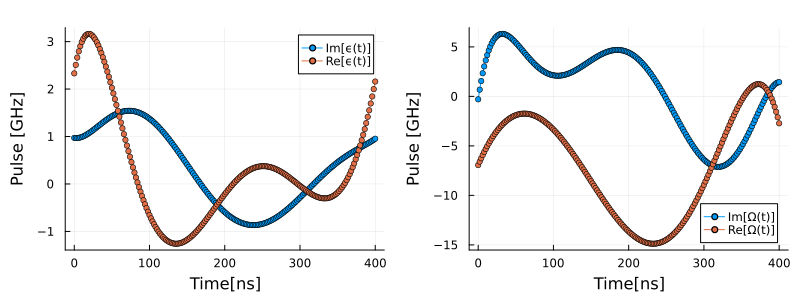

In [87]:
imaginary_part = plot([l for l in 0:T*2 / (200):T*2], imag(amps_c), label = "Im[ϵ(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, layout=2, subplot=1, size=(800,300), margin=5mm)
real_part = plot!([l for l in 0:T*2 / (200):T*2], real(amps_c), label= "Re[ϵ(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=1)
imaginary_part = plot!([l for l in 0:T*2 / (200):T*2], imag(amps_q), label = "Im[Ω(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=2)
real_part = plot!([l for l in 0:T*2 / (200):T*2], real(amps_q), label= "Re[Ω(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=2)

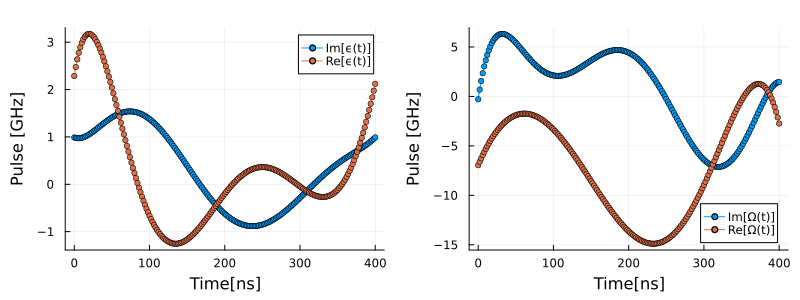

In [92]:
optimised_coeffs_3_bis = Optim.minimizer(res_reseding_2_bis)
coeffs_cavity = optimised_coeffs_3_bis[1:7]
coeffs_qubit = optimised_coeffs_3_bis[8:end]
amplitude_c(t) = chebyshev_amplitude(coeffs_cavity, T*2, t)
amplitude_q(t) = chebyshev_amplitude(coeffs_qubit, T*2, t)

amps_c = [amplitude_c(l) for l in 0:T*2/(200):T*2]
amps_q = [amplitude_q(l)  for l in 0:T*2/(200):T*2]

imaginary_part = plot([l for l in 0:T*2 / (200):T*2], imag(amps_c), label = "Im[ϵ(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, layout=2, subplot=1, size=(800,300), margin=5mm)
real_part = plot!([l for l in 0:T*2 / (200):T*2], real(amps_c), label= "Re[ϵ(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=1)
imaginary_part = plot!([l for l in 0:T*2 / (200):T*2], imag(amps_q), label = "Im[Ω(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=2)
real_part = plot!([l for l in 0:T*2 / (200):T*2], real(amps_q), label= "Re[Ω(t)]", linestyle=:dash, marker = :circle, markersize=3, xlabel="Time[ns]", ylabel="Pulse [GHz]", fmt = :PDF, subplot=2)

In [93]:
optimised_coeffs_3_bis = Optim.minimizer(res_reseding_2_bis)

14-element Vector{ComplexF64}:
   0.8233828686548157 + 0.544958412836546im
  -0.6557468274058194 - 0.40762308392520835im
    1.528560541179077 + 0.6569164723182975im
 -0.23309870196323998 + 0.5544355855757656im
  0.17780427179806604 - 0.3614578589883609im
   0.8058737710203586 - 0.14586513924341257im
  -0.3262240275681837 + 0.14844004311289463im
   -5.468556873272114 + 0.9144491253659993im
   1.0861162897229204 - 3.348866197077801im
    4.639394530566614 + 0.21919107386414705im
   2.5747277799455555 + 3.128696202663939im
   -3.771547171088111 + 1.5938973046362606im
  -1.5549832657720877 + 1.0945423324785992im
 -0.24482516208740535 - 2.1400587466258254im

In [97]:
Diagonal(exp.(im*rand(10)))

DimensionMismatch: DimensionMismatch: second dimension of A, 10, does not match first dimension of B, 8

In [140]:
f(t) = chebyshev_amplitude([0,0,0,1,0,1,0,1,0,1,0,1], T, t) - 5

f (generic function with 1 method)

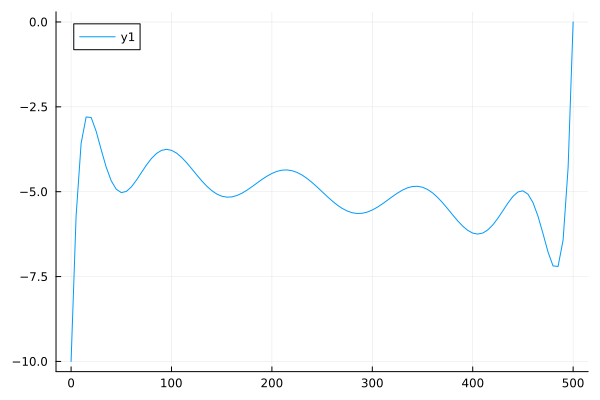

In [141]:
plot(0:T/100:T, [f(t) for t in 0:T/100:T])